In [20]:
import sys
sys.path.append ( '../ ')
"""
Basic I / O routines for the.h5 files
"""
import numpy as np
import pandas as pd
import os
import h5py
import pickle

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import joblib

from numpy.random import seed
import tensorflow as tf


from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences



# Visualization

In [21]:
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import seaborn  as sns
import h5py
from vispy import io
from matplotlib.pyplot import cm
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from cycler import cycler
import os
import subprocess
import glob
import matplotlib.image as mpimg


In [22]:
def plot_background_image (cs = False, alpha = 0.5):
    """
    Plotting the background image
    """

    background_image = io.image.imread(cs) # ../data/imagge
    fig, ax = plt.subplots()
    ax.imshow(background_image, cmap='gray', alpha = alpha)

def scatter_df (df, x_name = 'x_position', y_name = 'y_position', hue ="class_id", marker = ".", palette = "bright"):
    """ 
    Scattering a data-frame
    """ 
    sns.scatterplot(data = df, x = x_name, y = y_name, hue = hue, marker = marker, palette= palette)

def heat_df (df, x_name = 'x_position', y_name = 'y_position', bins = 50, cmap = "hot"):
    """ 
    Heatmap of a data-frame
    """ 
    sns.histplot(data = df, x = x_name, y = y_name, bins = bins, cbar = True, cmap = cmap)

def plot_trajectories(df, tracknrs = None, track_name = "track_id", class_name = "class_id", x_name = "x_position", y_name = "y_position", annotate=False, end_points=True, all_points =False, color_type ="class", extent=[-35,35,-35,35]):
    """ 
    Trajectories of dataframe 
    """ 
    background_image = mpimg.imread("/home/coder/viscando/data/Viscando_Koelliken_Trajectory_data/Koelliken_background_image.png") # ../data/imagge

    unique_tracknrs = df[track_name].unique()
    if(tracknrs is None):
        tracknrs = unique_tracknrs 
    fig, ax = plt.subplots()
    ax.imshow(background_image, cmap='gray', extent=[-35,35,-35,35], alpha = 0.5, aspect='auto')
    
    for track in tracknrs:
        if (track not in unique_tracknrs):
            continue
        colors =["red", "black", "blue", "yellow"]
        cl = int(df.loc[df[track_name]==track][class_name].iloc[0]%4)

        color = color_type
        if (color_type=="class"):
            color = colors[cl]
        if (color_type is None):
            color=None
        
        ax.plot(df.loc[df[track_name]==track][x_name], df.loc[df[track_name]==track][y_name], linewidth=0.5, color = color)

    if(color_type=="class"):
        blue_patch = mpatches.Patch(color ='red', label = '4| Pedestrian')
        red_patch = mpatches.Patch(color ='black', label = '1| Bicycle')
        green_patch=mpatches.Patch(color = 'blue', label = '18| light vehicle')
        yellow_patch = mpatches.Patch(color='yellow', label = '-1| unknow')
        ax.legend(title='class_id', handles=[red_patch, blue_patch, green_patch, yellow_patch], loc='upper right', bbox_to_anchor=(1,1))



# Get datta

In [23]:
def get_data_directory():
    """ 
    Gets the data Directory of the currenty system :return: current data directory

    """
    tmp = os.path.dirname(os.getcwd())
    if os.path.isdir('data'):
        return os.getcwd()
    else:
        return'{}/{}/{}/{}'. format(tmp, 'data', 'Viscando_Koelliken_Trajectory_data', 'Koelliken_offline_tracks_30min')


def get_img_path(cs=False):
    """
    Gets the path of image
    : param cs: True if with coordinate system, Default without
    """
    if (cs == False):
        img_path = 'background_img.png'
    else:
        img_path = 'background_img_cs.png'
    data_path = '{}/{}'. format(get_data_directory(), img_path)
    return data_path


def get_sensor_data_names():
    """
    Returns an list with the data names (- h5 - files)
    """
    return ['data_109.h5', 'data_130.h5', 'data_142.h5', 'data_143.h5']


def get_offline_data_name():
    """
    Returns the name for the OfflineTrack
    """
    return ['Otus3D_koelliken_30min.h5']


def get_offline_data_path():
    """get_offline_data_name()
    Returns the offline data path (concatenated)
    """
    l = ['{}/{}'.format(get_data_directory(), k) for k in get_offline_data_name()]
    return l


def read_offline_data(data_path=get_offline_data_path()[0], type="States", prediction=False):
    """
    Read in offline data
    : param data_path: optional data path
    : type: which key to take, default"States","Detections"to be implemented
    : return: pandas dataframe with offline data
    """
    if (not ((type =="States") | (type =="Detections"))):
        raise"Type needs to be either'Tracks'or'Detections'."
    hf = h5py.File(data_path)
    singlelist_all = ['Track', 'Height_m', 'Length_m', 'Width_m', 'Object_class']
    multlist_all = ['Predictions_time', 'Predictions_x', 'Predictions_y']
    if (prediction == False):
        multlist_all = ['X_local_coordinate_system', 'Y_local_coordinate_system', 'Z_local_coordinate_system', 'Acceleration_ms2', 'Heading_rad', 'Timestamps_UNIX', 'Velocity_ms']
    skiplist_all = ['Attributes']
    singlelist = []
    multlist = []
    skiplist = []
    some_key = list(hf['Tracks'].keys())[0]
    # add keys to single - mult - skiplist that in within h5 - df
    for key in hf["Tracks"][some_key][type]:
        # only add non - empty keys
        if (hf["Tracks"][some_key][type][key].shape[0] == 0):
            continue
        elif (key in singlelist_all):
            singlelist.append(key)
        elif (key in multlist_all):
            multlist.append(key)
        elif (key in skiplist_all):
            skiplist.append(key)
        # else:
        #     print("OBS ! Key { } not added".format(key))
    singlelist.append("Track")
    columns = singlelist + multlist
    # Get data into a numpy array / matrix and then into pandas dataframe
    alldata = np.zeros(shape=(1, len(columns)))
    for track in hf['Tracks'].keys():
        # Number of data points in each track
        if (prediction):
            ndatapoints = len(hf['Tracks'][track][type]['Predictions_x'])
            nattributes = len(columns)
        else:
            ndatapoints = len(hf['Tracks'][track][type]['X_local_coordinate_system'])
            nattributes = len(columns)
        # Initialise tmp
        tmpdata = np.zeros(shape=(ndatapoints, nattributes))
    # Single values
        for i, attribute in enumerate(singlelist):
            if (attribute == 'Track'):
                tmpdata[:, i] = int(track) * np.ones((ndatapoints, 1))[:, 0]
            elif ((attribute == 'Height_m') or (attribute == 'Length_m') or (attribute =='Width_m')):
                tmpdata[:, i] = float(hf['Tracks'][track][type][attribute][:]) * np.ones((
                    ndatapoints, 1))[:, 0]
            else:
                tmpdata[:, i] = int(hf['Tracks'][track][type][attribute][:]) * np.ones((
                    ndatapoints, 1))[:, 0]
        # Multiple values
        for j, attribute in enumerate(multlist):
            tmpdata[:, i + j +
                    1] = np.array(hf['Tracks'][track][type][attribute][:])
        # Stack tmp on all previous data
        alldata = np.vstack([alldata, tmpdata])
    # Put into datframe
    df = pd.DataFrame(alldata[1:, :], columns=columns)
    new_columnname = {'X_local_coordinate_system': 'x_position',
                      'Y_local_coordinate_system': 'y_position',
                      'Z_local_coordinate_system': 'z_position',
                      'Track': 'track_id',
                      'Object_class':"class_id",
                      'Timestamps_UNIX': 'timestamp',
                      'Predictions_x': 'x_position',
                      'Predictions_y': 'y_position',
                      'Predictions_time': 'timestamp',
                      }
    df = df.rename(columns=new_columnname)
    return df


def read_sensor_data(file_name='data_109.h5'):
    """
    Read in sensor data from one file
    : param file_name: file_name within data directory
    : return: pandas dataframe with offline data
    """
    hf = h5py.File('{}/{}'. format(get_data_directory(), file_name), 'r')

    # To iterate over
    timestamps = hf['Timestamp'][:]
    timestamps = np.sort(np.reshape(timestamps, (-1, 1)))
    seq_items = hf['Sequence'].items()

    # Names
    columns = ['index', 'timestamp', 'track_id', 'x_position', 'y_position', 'z_position', 'x_velocity', 'y_velocity', 'z_velocity', 'class_id', 'status']
    # Get data into a numpy array / matrix and then into pandas dataframe
    alldata = np.zeros(shape=(1, len(columns)))
    # For each frame,
    for idx, data in seq_items:
        ntracks_in_current_image = len(data['Tracks'][:])
        # For each track
        tmpdata = np.zeros(shape=(ntracks_in_current_image, 11))
        for i in range(ntracks_in_current_image):

            # index
            tmpdata[i, 0] = int(idx)

            # timestamp
            tmpdata[i, 1] = timestamps[int(idx)]

            # track id
            tmpdata[i, 2] = data['Tracks'][i][0]

            # positions, xyz
            tmpdata[i, 3] = data['Tracks'][i][1][0]
            tmpdata[i, 4] = data['Tracks'][i][1][1]
            tmpdata[i, 5] = data['Tracks'][i][1][2]

            # velocity, xyz
            tmpdata[i, 6] = data['Tracks'][i][2][0]
            tmpdata[i, 7] = data['Tracks'][i][2][1]
            tmpdata[i, 8] = data['Tracks'][i][2][2]

            # class id
            tmpdata[i, 9] = data['Tracks'][i][3]

            # status
            tmpdata[i, 10] = data['Tracks'][i][4]

    # Stack tmp on all previous data
        alldata = np.vstack([alldata, tmpdata])
    # Put into datframe
    df = pd.DataFrame(alldata[1:, :], columns=columns)
    return df


def pickle_df(df, file_name):
    """
    Pickles the datafile to the data directory
    """
    with open(get_data_directory() + '/df_' + file_name + '.pickle', 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)


def concat_df(dfs, sources):
    """
    Concatenates a list of dataframes, and adds the source .
    : params dfs: list of dataframes
    : sources: list of datasources, in the same order as dataframes
    : return: concatenated dataframe
    """
    for df, source in zip(dfs, sources):
        df["Source"] = source
    df = pd.concat(dfs, axis=0, ignore_index=True)
    return df


def read_full_sensor_data(names=get_sensor_data_names()):
    dfs = []
    sources = []
    for name in names:
        df = read_sensor_data(name)
        dfs.append(df)
        sources.append(name)
    df_full = concat_df(dfs, sources)
    return df_full


def read_pickle_data(file_name, full=False):
    """
    Reads data from pickled file and returns as data frame
    : params file_name: file name
    : full: True if full name is indicated, False if only the name of dataset
    : return: unpickled dataframes
    """
    if (full):
        full_name = get_data_directory() + '/' + file_name
    else:
        full_name = get_data_directory() + '/df_' + file_name + '.pickle'
    with open(full_name, 'rb') as f:
        df = pickle.load(f)
    return df


def sequence_it(hf, return_track=False):
    """Getting a sequence with images and corresponding tracks .
    : param hf: A.h5 sensor file .
    : return_track: boolean, False if does not return track, True o / w
    : return: List of tuples (index, image, tracks) in order .
    """
    # Initialise
    sequence = []
    # To iterate over
    ids = hf['Sequence'].items()
    timestamps_sensor = hf['Timestamp'][:]
    timestamps_sensor = np.sort(np.reshape(timestamps_sensor, (-1, 1)))
    if (return_track):
        wtc = np.array(hf['TMatrixWorldToCam'][:])
        cti = np.array(hf['ProjectionMatrix'][:])
    # For each image,
    for name, value in ids:
        if (return_track == False):
            sequence += [(int(name), value['Image'][:])]
        else:
            ntracks_in_current_image = len(value['Tracks'][:])
        # For each track
            positions = np.zeros(shape=(ntracks_in_current_image, 2))
            for i in range(ntracks_in_current_image):
                pos = plot.world_to_image(np.array(value['Tracks'][i][1].tolist()), wtc, cti)
                positions[i, :] = pos[:]
            sequence += [(int(name), value['Image'][:], positions)]
    # In order
    sequence.sort(key=lambda tup: tup[0])
    return (sequence)

In [24]:
df = read_offline_data(data_path=get_offline_data_path()[0], type="States", prediction=False)
df['timestamp'] = df['timestamp'] - 1574333100

# read_sensor_data(file_name='data_109.h5')
df

,Height_m,Length_m,class_id,Width_m,track_id,Acceleration_ms2,Heading_rad,timestamp,Velocity_ms,x_position,y_position,z_position
0,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,0.041,0.000000,-23.055373,-1.587022,-1.032926
1,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,0.121,0.000000,-23.030131,-1.701481,-1.054342
2,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,0.201,0.000000,-22.988431,-1.812903,-1.104315
3,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,0.281,0.000000,-22.945297,-1.932856,-1.056968
4,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,0.361,1.531463,-22.911321,-2.051077,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
123855,1.339808,5.681589,18.0,1.984803,999.0,0.0,0.0,920.361,6.768232,12.195475,-6.775881,1.000000
123856,1.339808,5.681589,18.0,1.984803,999.0,0.0,0.0,920.521,8.094957,12.308388,-8.507507,1.000000
123857,1.339808,5.681589,18.0,1.984803,999.0,0.0,0.0,920.601,8.435593,12.460485,-9.320528,1.000000
123858,1.339808,5.681589,18.0,1.984803,999.0,0.0,0.0,920.681,8.362752,12.432770,-9.961214,1.000000


In [25]:
print('Number of pedestrian tracks: ',len(df[(df['class_id'] == 4)]['track_id'].unique()))
print('Number of bicycle tracks: ', len(df[(df['class_id'] == 1)]['track_id'].unique()))
print('Number of light vehicle tracks: ', len(df[(df['class_id'] == 18)]['track_id'].unique()))
print('Number of other tracks: ', len(df[(df['class_id'] == -1)]['track_id'].unique()))

Number of pedestrian tracks:  255
Number of bicycle tracks:  44
Number of light vehicle tracks:  1625
Number of other tracks:  629


# Data preprocessing

Filter out tracks having number of sequence < 30 points

In [26]:
for tid, nb in df['track_id'].value_counts().items():
    # print('trac id :' + str(tid) + ' nbr:' + str(nb))
    #Filter out tracks with number of points < 50 or > 300
    if nb < 30:
        df = df.drop(df[df.track_id == tid].index)
df

,Height_m,Length_m,class_id,Width_m,track_id,Acceleration_ms2,Heading_rad,timestamp,Velocity_ms,x_position,y_position,z_position
0,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,0.041,0.000000,-23.055373,-1.587022,-1.032926
1,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,0.121,0.000000,-23.030131,-1.701481,-1.054342
2,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,0.201,0.000000,-22.988431,-1.812903,-1.104315
3,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,0.281,0.000000,-22.945297,-1.932856,-1.056968
4,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,0.361,1.531463,-22.911321,-2.051077,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
123855,1.339808,5.681589,18.0,1.984803,999.0,0.0,0.0,920.361,6.768232,12.195475,-6.775881,1.000000
123856,1.339808,5.681589,18.0,1.984803,999.0,0.0,0.0,920.521,8.094957,12.308388,-8.507507,1.000000
123857,1.339808,5.681589,18.0,1.984803,999.0,0.0,0.0,920.601,8.435593,12.460485,-9.320528,1.000000
123858,1.339808,5.681589,18.0,1.984803,999.0,0.0,0.0,920.681,8.362752,12.432770,-9.961214,1.000000


In [27]:
df_ped = df[(df['class_id'] == 4)]
df_ped

,Height_m,Length_m,class_id,Width_m,track_id,Acceleration_ms2,Heading_rad,timestamp,Velocity_ms,x_position,y_position,z_position
0,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,0.041,0.000000,-23.055373,-1.587022,-1.032926
1,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,0.121,0.000000,-23.030131,-1.701481,-1.054342
2,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,0.201,0.000000,-22.988431,-1.812903,-1.104315
3,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,0.281,0.000000,-22.945297,-1.932856,-1.056968
4,1.591612,1.590598,4.0,0.854206,0.0,0.0,0.0,0.361,1.531463,-22.911321,-2.051077,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
123222,1.420644,1.086775,4.0,0.618986,988.0,0.0,0.0,908.281,1.333666,-20.087341,9.170598,1.000000
123223,1.420644,1.086775,4.0,0.618986,988.0,0.0,0.0,908.361,1.389879,-20.209976,9.118313,1.000000
123224,1.420644,1.086775,4.0,0.618986,988.0,0.0,0.0,908.441,1.366703,-20.308529,9.096690,1.000000
123225,1.420644,1.086775,4.0,0.618986,988.0,0.0,0.0,908.521,1.399112,-20.426428,9.057911,1.000000


In [28]:
df_pos_ped = df_ped[['track_id', 'timestamp','x_position','y_position']]
print(df_pos_ped)

        track_id  timestamp  x_position  y_position
0            0.0      0.041  -23.055373   -1.587022
1            0.0      0.121  -23.030131   -1.701481
2            0.0      0.201  -22.988431   -1.812903
3            0.0      0.281  -22.945297   -1.932856
4            0.0      0.361  -22.911321   -2.051077
...          ...        ...         ...         ...
123222     988.0    908.281  -20.087341    9.170598
123223     988.0    908.361  -20.209976    9.118313
123224     988.0    908.441  -20.308529    9.096690
123225     988.0    908.521  -20.426428    9.057911
123226     988.0    908.601  -20.530268    9.031578

[15936 rows x 4 columns]


Clustering

In [29]:
import numpy as np
import pandas as pd
from scipy . spatial . distance import directed_hausdorff

In [30]:
def hausdorff(u,v):
    return max(directed_hausdorff(u,v)[0], directed_hausdorff(v,u)[0])

def dir_hausdorff(u,v):
    return directed_hausdorff(u,v)[0]

In [31]:
def extract_track (df ,i , trackkey ="track_id", keys_to_extract =["x_position","y_position"]):

    df=df.loc[df[trackkey]==i][keys_to_extract]
    stacked =np.array ( df[keys_to_extract[0]])
    for key in keys_to_extract [1:]:
        ys=np.array(df[key])
        stacked =np.stack ((stacked , ys) , axis =-1)
    return stacked
def extract_tracks (df, tracknrs, nr_tracks =None , trackkey ="track_id", keys_to_extract = ["x_position","y_position"]):
    if( nr_tracks is None ):
        nr_tracks = len ( df[ trackkey ]. unique () )
    tracks =[]
    for i in tracknrs [:nr_tracks]:
        tracks . append ( extract_track (df ,i , trackkey = trackkey , keys_to_extract = keys_to_extract ))
    return tracks

tracks = extract_tracks (df , tracknrs = df["track_id"].unique(), nr_tracks =None , trackkey ="track_id", keys_to_extract = ["x_position","y_position"])

In [32]:
def compute_distances(tracks, type="all", print_status=False):
    if(not (type == "all" or type == "hausdorff" or type == "frechet")):
        raise ValueError(" type must be all , hausdorff or frechet ")
    nr_tracks = len(tracks)
    if(type == "all" or type == "hausdorff"):
        distances = np.zeros((nr_tracks, nr_tracks))
    if(type == "all" or type == "frechet"):
        fdistances = np.zeros((nr_tracks, nr_tracks))
    for nri in range(nr_tracks):
        u = tracks[nri]
        for nrj in range(nr_tracks):
            if(nri < nrj):
                continue
            v = tracks[nrj]
            if(type == "all" or type == "hausdorff"):
                distances[nri][nrj] = hausdorff(u, v)
                distances[nrj][nri] = distances[nri][nrj]  # symmetric
            if(type == "all" or type == "frechet"):
                fdistances[nri][nrj] = frechet(u, v)
                fdistances[nrj][nri] = fdistances[nri][nrj]
    if(print_status == True and nri % 25 == 0):
        print("nri = {}". format(nri))
    if(type == "all"):
        return distances, fdistances
    if(type == "hausdorff"):
        return distances
    if(type == "frechet"):
        return fdistances


In [33]:
dist = compute_distances(tracks, type ="hausdorff", print_status = False)

In [34]:
from sklearn.cluster import DBSCAN
def dbscan(dist,eps =9,min_samples =20):
    a= DBSCAN (eps =eps , min_samples = min_samples , metric ="euclidean").fit(dist)
    return a

a = dbscan(dist=dist,eps =9,min_samples =20)

In [35]:
labels  = a.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)


Estimated number of clusters: 2
Estimated number of noise points: 1275


In [36]:
def label_outliers ( clustering , df , tracknrs , nr_tracks , trackkey ="track_id",outlierkey ="outlier", not_assigned =-1 ,use_labels_ = True ):
    df[outlierkey] = not_assigned
    for i , track in enumerate ( tracknrs [: nr_tracks ]):
        if( use_labels_ ):
            df.loc[df[trackkey]==track , outlierkey]= clustering.labels_ [i]
        else :
            df.loc[df[trackkey]==track , outlierkey]= clustering[i]
    return df

def get_outlier_from_clustering (cl , tracknrs , outlier_value =-1):

    l=[]
    for a ,b in zip ( cl . labels_ , tracknrs ):
        if(a== outlier_value ):
            l. append (b)
    return l
df_label = label_outliers ( a , df_ped , tracknrs = df_ped["track_id"].unique() , nr_tracks = len(tracks), trackkey ="track_id",outlierkey =" outlier ", not_assigned =-1 ,use_labels_ = True )

df_outliers_l = get_outlier_from_clustering (a , tracknrs = df_label["track_id"].unique(), outlier_value =-1)

df_normal = df_ped.copy()  # Create a copy of the original DataFrame

for track in df_outliers_l:
    print(track)
    df_normal = df_normal.drop(df_normal[df_normal.track_id == track].index)


/tmp/ipykernel_764566/500103793.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[outlierkey] = not_assigned


0.0
1018.0
1039.0
1084.0
1095.0
1204.0
1218.0
1235.0
1236.0
126.0
1267.0
13.0
1340.0
1344.0
1359.0
144.0
1448.0
1451.0
148.0
1684.0
17.0
1720.0
1726.0
173.0
1760.0
1766.0
1796.0
1859.0
187.0
1882.0
1899.0
1966.0
197.0
199.0
200.0
206.0
2108.0
2126.0
2134.0
2152.0
2155.0
2166.0
2168.0
217.0
2180.0
2195.0
2201.0
2205.0
2215.0
2249.0
2266.0
2288.0
229.0
2292.0
2313.0
2330.0
2333.0
2357.0
2364.0
2381.0
2382.0
2389.0
2399.0
243.0
2442.0
2456.0
2462.0
2476.0
2480.0
2486.0
2490.0
2521.0
2539.0
2552.0
269.0
274.0
280.0
282.0
286.0
291.0
315.0
320.0
322.0
329.0
330.0
332.0
365.0
388.0
396.0
413.0
414.0
417.0
473.0
519.0
534.0
560.0
604.0
611.0
634.0
643.0
654.0
71.0
711.0
749.0
790.0
843.0
860.0
87.0
886.0
898.0
899.0
933.0
955.0
963.0
976.0
988.0


Normal trajectories of pedestrians and light vehicle by applying DBSCAN clustering method

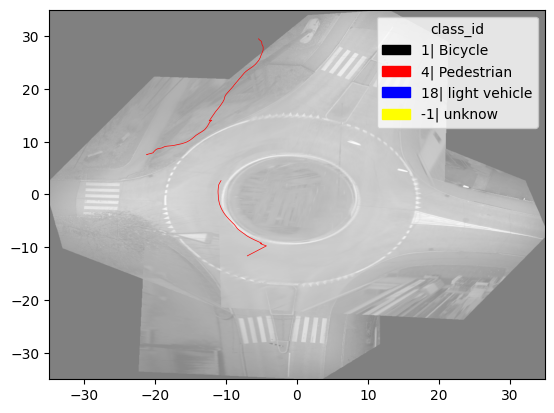

In [37]:
plot_trajectories(df_normal, tracknrs = None, track_name = "track_id", class_name = "class_id", x_name = "x_position", y_name = "y_position", annotate=False, end_points=True, all_points =False, color_type ="class", extent=[-35,35,-35,35])

Outliers filtering

In [38]:
def get_tracklength(dfo_track):
    """ 
    Read offline data
    """ 
    dfo_track = dfo_track.sort_values(by=['timestamp'])

    pos = dfo_track[['x_position', 'y_position']]
    n_pos = len(pos.index)
    length = 0
    for i in range(n_pos - 1):
        length += np.sqrt(np.sum((pos.iloc[i].values - pos.iloc[i+1].values) ** 2, axis = 0))
    return (length)

In [39]:
#Filter outliers
def filter_odd(dfo, tracknrs = None, min_nr = 15, min_len = 8, track_name = 'track_id'):
    unique_tracknrs = dfo[track_name].unique()
    if(tracknrs is None):
        tracknrs = unique_tracknrs
    
    dfo['track_len']=0
    for track in tracknrs:
        tmp=len(dfo.loc[dfo[track_name]==track])
        dfo.loc[dfo[track_name]==track, 'track_len'] = tmp

    dfo['bird_dist'] = 0
    for track in tracknrs:
        x1 = dfo.loc[dfo[track_name]==track]['x_position'].iloc[0]
        y1 = dfo.loc[dfo[track_name]==track]['y_position'].iloc[0]
        x2 = dfo.loc[dfo[track_name]==track]['x_position'].iloc[-1]
        y2 = dfo.loc[dfo[track_name]==track]['y_position'].iloc[-1]
        tmp = np.sqrt((x1-x2)**2 + (y1-y2)**2)
        dfo.loc[dfo[track_name] == track, "bird_dist"] = tmp

    dfo_outliers = dfo.loc[(dfo["track_len"] <= min_nr) | (dfo["bird_dist"] <= min_len)]
    dfo_inliers = dfo.loc[(dfo["track_len"] > min_nr) | (dfo["bird_dist"] > min_len)]

    return dfo_outliers, dfo_inliers

In [40]:
#df_descriptors = track_properties(df_ped_vehicle)
dfo2_outliers, dfo2_inliers = filter_odd(df_ped, tracknrs = None, min_nr =5, min_len = 5, track_name = 'track_id')

/tmp/ipykernel_764566/1782097930.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfo['track_len']=0
/tmp/ipykernel_764566/1782097930.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfo['bird_dist'] = 0


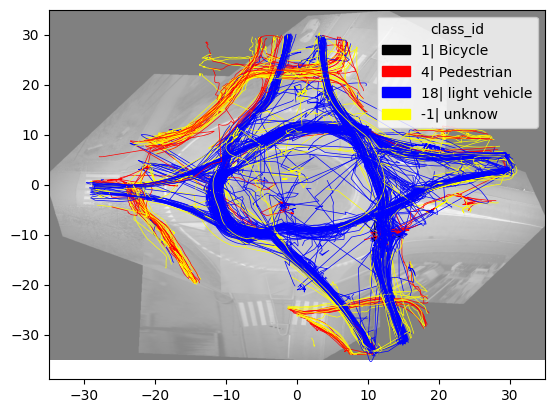

In [41]:
plot_trajectories(df, tracknrs = None, track_name = "track_id", class_name = "class_id", x_name = "x_position", y_name = "y_position", annotate=False, end_points=True, all_points =False, color_type ="class", extent=[-35,35,-35,35])

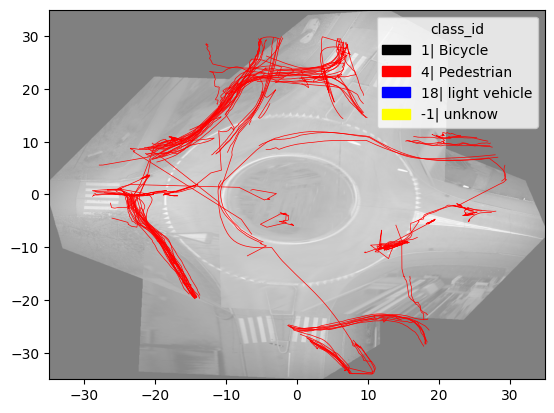

In [42]:
plot_trajectories(df_ped, tracknrs = None, track_name = "track_id", class_name = "class_id", x_name = "x_position", y_name = "y_position", annotate=False, end_points=True, all_points =False, color_type ="class", extent=[-35,35,-35,35])

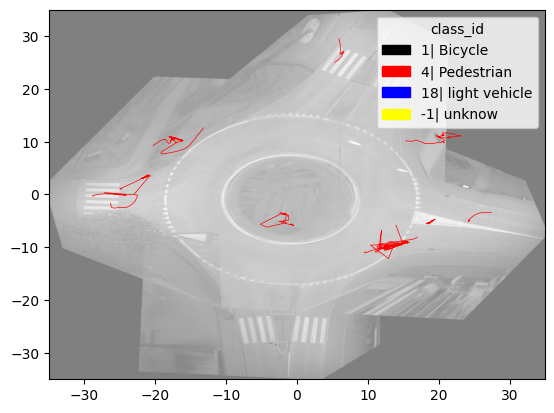

In [43]:
plot_trajectories(dfo2_outliers, tracknrs = None, track_name = "track_id", class_name = "class_id", x_name = "x_position", y_name = "y_position", annotate=False, end_points=True, all_points =False, color_type ="class", extent=[-35,35,-35,35])

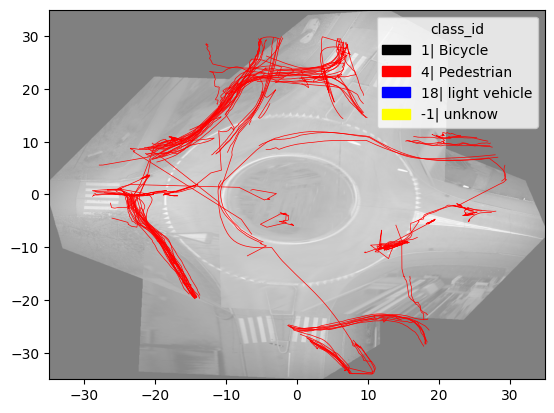

In [44]:
plot_trajectories(dfo2_inliers, tracknrs = None, track_name = "track_id", class_name = "class_id", x_name = "x_position", y_name = "y_position", annotate=False, end_points=True, all_points =False, color_type ="class", extent=[-35,35,-35,35])

In [45]:
import numpy as np
from scipy.interpolate import interp1d

def resample_trajectory(trajectory, length):
    # Assuming 'trajectory' is a 2D array with shape (N, 2),
    # where N is the original length of the trajectory
    
    # Create an array of indices based on the original trajectory length
    indices = np.arange(len(trajectory))
    
    # Create an array of indices for the desired resampled length
    resampled_indices = np.linspace(0, len(trajectory)-1, length)
    
    # Interpolate the trajectory using linear interpolation
    interp_func = interp1d(indices, trajectory, axis=0, kind='linear')
    
    # Evaluate the interpolated function at resampled indices
    resampled_trajectory = interp_func(resampled_indices)
    
    return resampled_trajectory


In [46]:
# Step 1: Data Collection
tracks_inliers = dfo2_inliers['track_id'].unique()

tracks_outliers = dfo2_outliers['track_id'].unique()

# Step 2 Data Normalization
scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_inliers_data = dfo2_inliers.copy()
normalized_inliers_data[['x_position', 'y_position']] = scaler.fit_transform(normalized_inliers_data[['x_position', 'y_position']])

scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_outliers_data = dfo2_outliers.copy()
normalized_outliers_data[['x_position', 'y_position']] = scaler.fit_transform(normalized_outliers_data[['x_position', 'y_position']])



In [47]:
#Step 3: Sequence creation for inliers trajectory
sequence_length = 30  # Number of time step
trajectory_inliers = np.zeros((len(tracks_inliers), 30, 2))
for i, track in enumerate(tracks_inliers):
    track_inliers_data = normalized_inliers_data[normalized_inliers_data['track_id'] == track]
    inliers_sequence = []
    resample_inliers_sequences = []
    for j in range(len(track_inliers_data)):
        
        inliers_sequence.append(track_inliers_data[['x_position', 'y_position']].values)
    inliers_sequences = np.array(inliers_sequence)
    #print(inliers_sequences.shape)
    inliers_sequences = inliers_sequences[0,:,:]
    #print(inliers_sequences.shape)
    resample_inliers_sequences = resample_trajectory(inliers_sequences, sequence_length)
    array_resample_inliers_sequences = np.array(resample_inliers_sequences)
    trajectory_inliers[i, ...] = array_resample_inliers_sequences
    #print(array_resample_inliers_sequence.shape)
    


In [48]:
trajectory_inliers.shape

(118, 30, 2)

In [49]:
#Step 3: Sequence creation for outliers trajectory
sequence_length = 30  # Number of time step
trajectory_outliers = np.zeros((len(tracks_outliers), 30, 2))
for i, track in enumerate(tracks_outliers):
    track_outliers_data = normalized_outliers_data[normalized_outliers_data['track_id'] == track]
    outliers_sequence = []
    resample_outliers_sequences = []
    for j in range(len(track_outliers_data)):
        
        outliers_sequence.append(track_outliers_data[['x_position', 'y_position']].values)
    outliers_sequences = np.array(outliers_sequence)
    #print(inliers_sequences.shape)
    outliers_sequences = outliers_sequences[0,:,:]
    #print(inliers_sequences.shape)
    resample_outliers_sequences = resample_trajectory(outliers_sequences, sequence_length)
    array_resample_outliers_sequences = np.array(resample_outliers_sequences)
    trajectory_outliers[i, ...] = array_resample_outliers_sequences
    #print(array_resample_inliers_sequence.shape)
    


In [50]:
normal_data = trajectory_inliers
anomalous_data = trajectory_outliers
print(normal_data.shape)

(118, 30, 2)


In [51]:
normal_train_data, normal_test_data = train_test_split(normal_data, test_size= 0.2, random_state=21)
anomalous_train_data, anomalous_test_data = train_test_split(anomalous_data, test_size=0.2, random_state=21)
print(normal_train_data.shape)

(94, 30, 2)


Plot a normal trajectory

Text(0.5, 1.0, 'A normal trajectory')

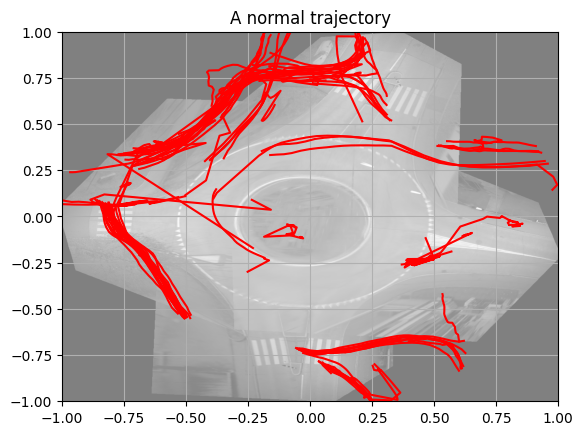

In [52]:
background_image = mpimg.imread("/home/coder/viscando/data/Viscando_Koelliken_Trajectory_data/Koelliken_background_image.png") # ../data/imagge
fig, ax = plt.subplots()
ax.imshow(background_image, cmap='gray', extent=[-1,1,-1,1], alpha = 0.5, aspect='auto')
ax.grid()
for i in range(len(normal_train_data)):
    ax.plot(normal_train_data[i][:,0], normal_train_data[i][:,1], '-r')
ax.set_title("A normal trajectory")
#ax.show()


    
    

Plot anomalous trajectory

Text(0.5, 1.0, 'A abnormal trajectory')

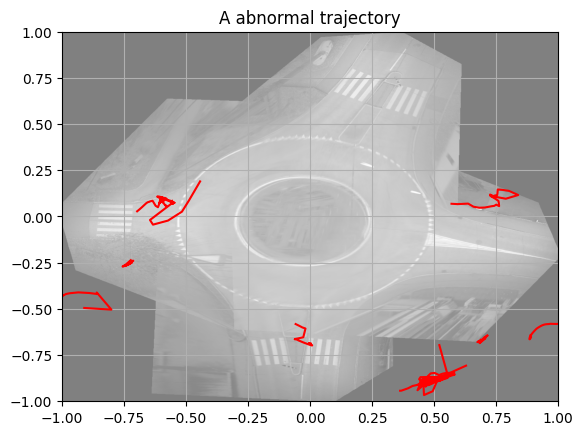

In [53]:
background_image = mpimg.imread("/home/coder/viscando/data/Viscando_Koelliken_Trajectory_data/Koelliken_background_image.png") # ../data/imagge
fig, ax = plt.subplots()
ax.imshow(background_image, cmap='gray', extent=[-1,1,-1,1], alpha = 0.5, aspect='auto')
ax.grid()
for i in range(len(anomalous_train_data)):
    ax.plot(anomalous_train_data[i][:,0], anomalous_train_data[i][:,1], '-r')
ax.set_title("A abnormal trajectory")
#ax.show()

In [54]:
model1 = Sequential()
model1.add(tf.keras.layers.Masking(mask_value = 0.0, input_shape = (normal_train_data.shape[1], normal_train_data.shape[2])))
model1.add(LSTM(64, activation = 'relu', return_sequences = True))
model1.add(LSTM(32, activation = 'relu', return_sequences = True))
model1.add(LSTM(16, activation = 'relu'))
model1.add(RepeatVector(normal_train_data.shape[1]))
model1.add(LSTM(16, activation = 'relu', return_sequences = True))
model1.add(LSTM(32, activation = 'relu', return_sequences = True))
model1.add(LSTM(64, activation = 'relu', return_sequences = True))
model1.add(TimeDistributed(Dense(normal_train_data.shape[2])))

2023-06-02 12:19:59.628579: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-02 12:19:59.628645: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: 7e40382b4c4f
2023-06-02 12:19:59.628794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: 7e40382b4c4f
2023-06-02 12:19:59.629222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.30.2
2023-06-02 12:19:59.629244: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.30.2
2023-06-02 12:19:59.629251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 530.30.2


In [55]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mae')
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 30, 2)             0         
                                                                 
 lstm (LSTM)                 (None, 30, 64)            17152     
                                                                 
 lstm_1 (LSTM)               (None, 30, 32)            12416     
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 repeat_vector (RepeatVector  (None, 30, 16)           0         
 )                                                               
                                                                 
 lstm_3 (LSTM)               (None, 30, 16)            2112      
                                                        

In [56]:
# fit the model to the data
nb_epochs =100
batch_size = 5
history = model1.fit(normal_train_data, normal_train_data, epochs=nb_epochs, batch_size=batch_size,
                    validation_data = (anomalous_test_data, anomalous_test_data)).history

Epoch 1/100
19/19 [==============================] - 15s 204ms/step - loss: 0.4602 - val_loss: 0.5513
Epoch 2/100
19/19 [==============================] - 3s 141ms/step - loss: 0.4590 - val_loss: 0.5500
Epoch 3/100
19/19 [==============================] - 2s 129ms/step - loss: 0.4572 - val_loss: 0.5479
Epoch 4/100
19/19 [==============================] - 3s 133ms/step - loss: 0.4542 - val_loss: 0.5440
Epoch 5/100
19/19 [==============================] - 2s 130ms/step - loss: 0.4487 - val_loss: 0.5359
Epoch 6/100
19/19 [==============================] - 3s 140ms/step - loss: 0.4373 - val_loss: 0.5131
Epoch 7/100
19/19 [==============================] - 2s 127ms/step - loss: 0.4017 - val_loss: 0.4788
Epoch 8/100
19/19 [==============================] - 3s 149ms/step - loss: 0.3344 - val_loss: 0.3730
Epoch 9/100
19/19 [==============================] - 3s 136ms/step - loss: 0.3085 - val_loss: 0.3713
Epoch 10/100
19/19 [==============================] - 2s 130ms/step - loss: 0.3002 - val_l

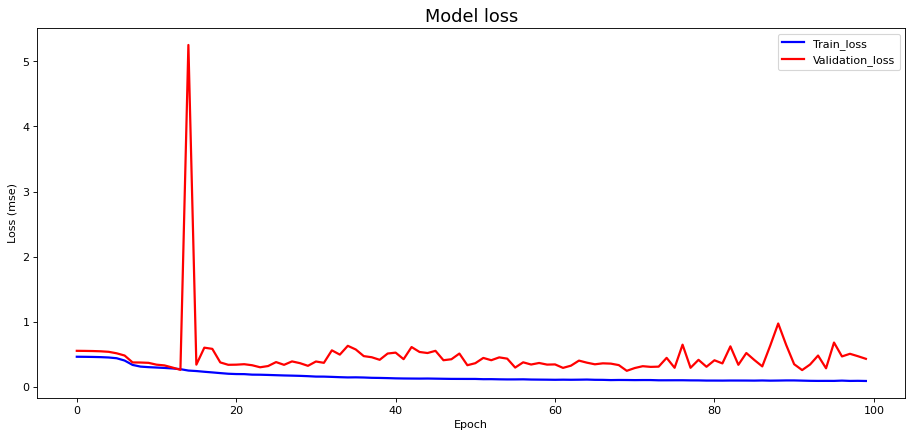

In [57]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train_loss', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation_loss', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mse)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

3/3 [==============================] - 1s 30ms/step


/tmp/ipykernel_764566/2751096184.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored, bins = 20, kde= True, color = 'blue');


(0.0, 1.0)

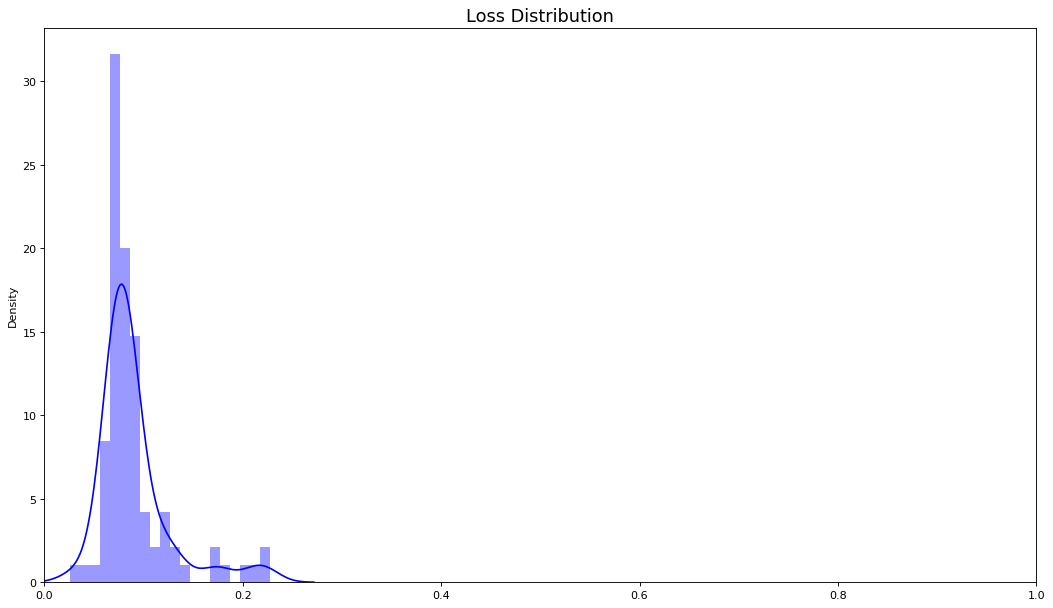

In [58]:
# plot the loss distribution of the training set
X_pred = model1.predict(normal_train_data)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1]*X_pred.shape[2])

Xtrain = normal_train_data.reshape(normal_train_data.shape[0], normal_train_data.shape[1]*normal_train_data.shape[2])
scored = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored, bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,1.0])

In [89]:
threshold = np.mean(scored) + 0.5*np.std(scored)
print("Threshold:", threshold)

Threshold: 0.09339895180625024


Number of normal tracks: 69


Text(0.5, 1.0, 'A normal trajectory')

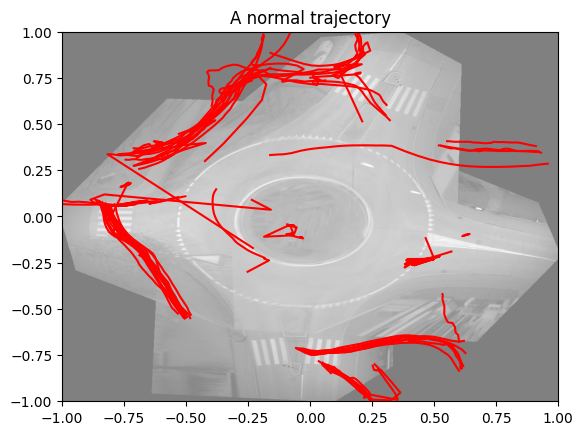

In [95]:
background_image = mpimg.imread("/home/coder/viscando/data/Viscando_Koelliken_Trajectory_data/Koelliken_background_image.png") # ../data/imagge
# Set the threshold score

# Filter the normal_train_data based on the threshold score
filtered_data = normal_train_data[scored < threshold]
print('Number of normal tracks:', len(filtered_data))
# # Reshape the filtered data if needed
# filtered_data = filtered_data.reshape(filtered_data.shape[0], filtered_data.shape[1], filtered_data.shape[2])
fig, ax = plt.subplots()
ax.imshow(background_image, cmap='gray', extent=[-1,1,-1,1], alpha = 0.5, aspect='auto')
# Plot the filtered data
for i in range(len(filtered_data)):
    ax.plot(filtered_data[i][:,0], filtered_data[i][:,1], '-r')
ax.set_title("A normal trajectory")
#ax.show()

Number of abnormal tracks: 25


Text(0.5, 1.0, 'A abnormal trajectory')

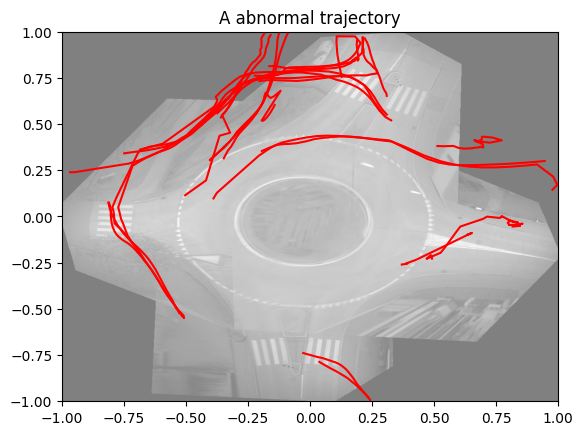

In [96]:
background_image = mpimg.imread("/home/coder/viscando/data/Viscando_Koelliken_Trajectory_data/Koelliken_background_image.png") # ../data/imagge
# Set the threshold score

# Filter the normal_train_data based on the threshold score
filtered_data = normal_train_data[scored > threshold]
print('Number of abnormal tracks:', len(filtered_data))
# # Reshape the filtered data if needed
# filtered_data = filtered_data.reshape(filtered_data.shape[0], filtered_data.shape[1], filtered_data.shape[2])
fig, ax = plt.subplots()
ax.imshow(background_image, cmap='gray', extent=[-1,1,-1,1], alpha = 0.5, aspect='auto')
# Plot the filtered data
for i in range(len(filtered_data)):
    ax.plot(filtered_data[i][:,0], filtered_data[i][:,1], '-r')
ax.set_title("A abnormal trajectory")
#ax.show()

# LSTM Autoencoder model 2

In [61]:
model2 = Sequential()
model2.add(tf.keras.layers.Masking(mask_value = 0.0, input_shape = (normal_train_data.shape[1], normal_train_data.shape[2])))
model2.add(LSTM(80, activation = 'relu', return_sequences = True))
model2.add(LSTM(40, activation = 'relu', return_sequences = True))
model2.add(LSTM(5, activation = 'relu'))
model2.add(RepeatVector(normal_train_data.shape[1]))
model2.add(LSTM(5, activation = 'relu', return_sequences = True))
model2.add(LSTM(40, activation = 'relu', return_sequences = True))
model2.add(LSTM(80, activation = 'relu', return_sequences = True))
model2.add(TimeDistributed(Dense(normal_train_data.shape[2])))

In [62]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, 30, 2)             0         
                                                                 
 lstm_6 (LSTM)               (None, 30, 80)            26560     
                                                                 
 lstm_7 (LSTM)               (None, 30, 40)            19360     
                                                                 
 lstm_8 (LSTM)               (None, 5)                 920       
                                                                 
 repeat_vector_1 (RepeatVect  (None, 30, 5)            0         
 or)                                                             
                                                                 
 lstm_9 (LSTM)               (None, 30, 5)             220       
                                                      

In [63]:
# fit the model to the data
nb_epochs =100
batch_size = 32
history = model2.fit(normal_train_data, normal_train_data, epochs=nb_epochs, batch_size=batch_size,
                    validation_data = (normal_test_data, normal_test_data)).history

Epoch 1/100
3/3 [==============================] - 12s 864ms/step - loss: 0.4607 - val_loss: 0.4662
Epoch 2/100
3/3 [==============================] - 1s 257ms/step - loss: 0.4596 - val_loss: 0.4651
Epoch 3/100
3/3 [==============================] - 1s 255ms/step - loss: 0.4580 - val_loss: 0.4632
Epoch 4/100
3/3 [==============================] - 1s 209ms/step - loss: 0.4551 - val_loss: 0.4602
Epoch 5/100
3/3 [==============================] - 1s 211ms/step - loss: 0.4490 - val_loss: 0.4539
Epoch 6/100
3/3 [==============================] - 1s 220ms/step - loss: 0.4347 - val_loss: 0.4386
Epoch 7/100
3/3 [==============================] - 1s 286ms/step - loss: 0.3975 - val_loss: 0.4234
Epoch 8/100
3/3 [==============================] - 1s 231ms/step - loss: 0.3803 - val_loss: 0.4130
Epoch 9/100
3/3 [==============================] - 1s 314ms/step - loss: 0.3675 - val_loss: 0.3976
Epoch 10/100
3/3 [==============================] - 1s 270ms/step - loss: 0.3436 - val_loss: 0.3768
Epoch 11

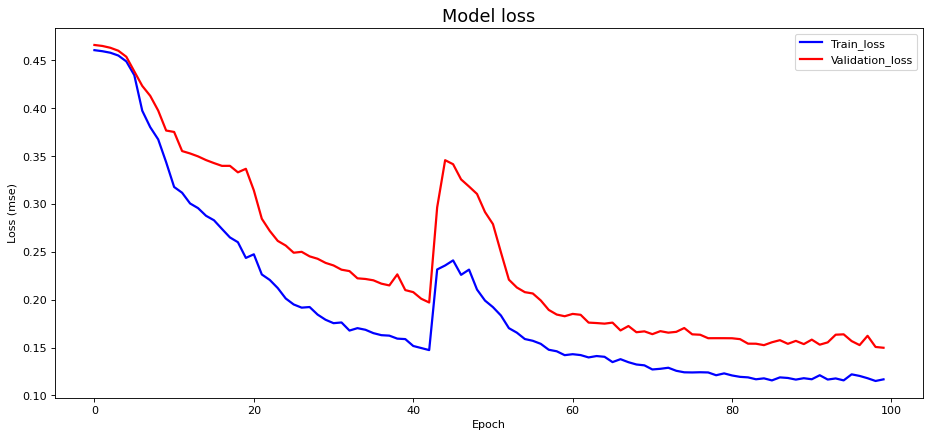

In [64]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train_loss', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation_loss', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mse)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

3/3 [==============================] - 1s 62ms/step


/tmp/ipykernel_764566/3023718132.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored, bins = 20, kde= True, color = 'blue');


(0.0, 1.0)

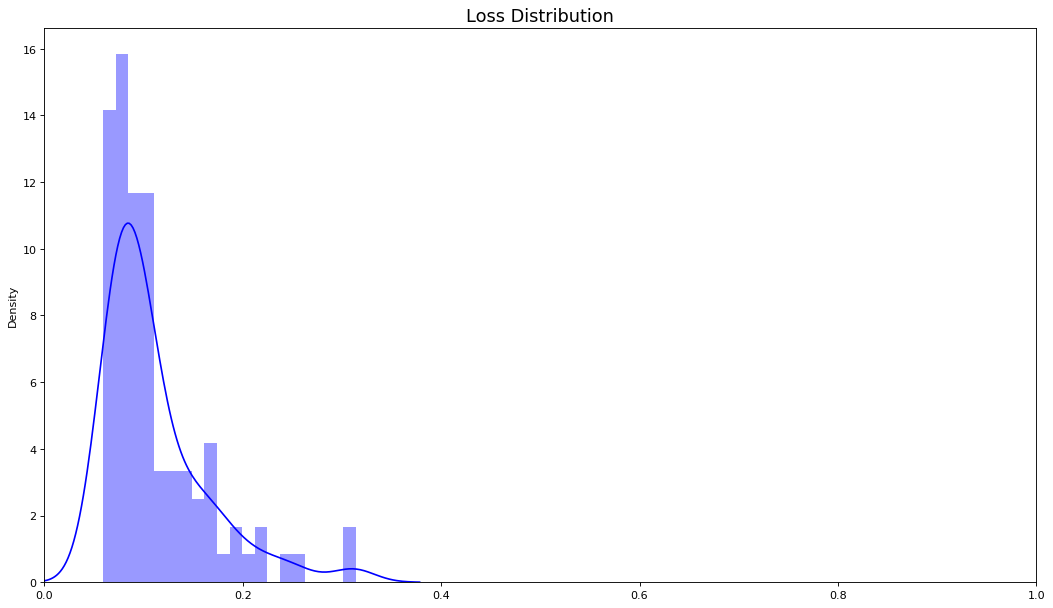

In [65]:
# plot the loss distribution of the training set
X_pred = model2.predict(normal_train_data)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1]*X_pred.shape[2])

Xtrain = normal_train_data.reshape(normal_train_data.shape[0], normal_train_data.shape[1]*normal_train_data.shape[2])
scored = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored, bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,1.0])

1/1 [==============================] - 0s 109ms/step


/tmp/ipykernel_764566/2748586762.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_scored, bins = 20, kde= True, color = 'blue');


(0.0, 1.0)

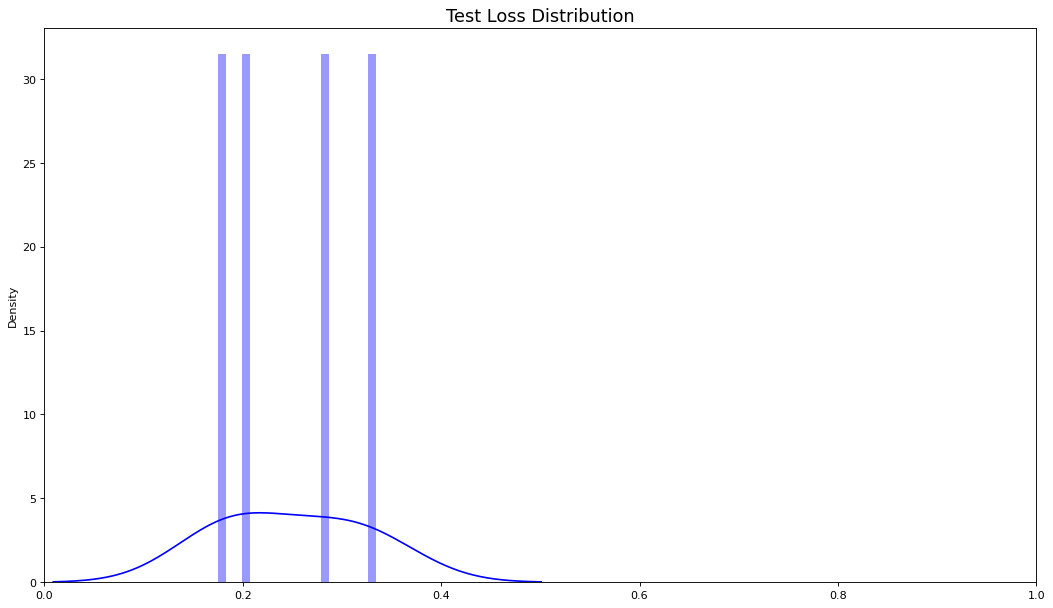

In [66]:
# plot the loss distribution of the training set
X_pred_test = model2.predict(anomalous_test_data)
X_pred_test = X_pred_test.reshape(X_pred_test.shape[0], X_pred_test.shape[1]*X_pred_test.shape[2])

Xtest = anomalous_test_data.reshape(anomalous_test_data.shape[0], anomalous_test_data.shape[1]*anomalous_test_data.shape[2])
test_scored = np.mean(np.abs(X_pred_test-Xtest), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Test Loss Distribution', fontsize=16)
sns.distplot(test_scored, bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,1.0])

Model 3

In [75]:
model3 = Sequential()
model3.add(tf.keras.layers.Masking(mask_value = 0.0, input_shape = (normal_train_data.shape[1], normal_train_data.shape[2])))
model3.add(LSTM(32, activation = 'relu', return_sequences = True))
model3.add(LSTM(16, activation = 'relu', return_sequences = True))
model3.add(LSTM(8, activation = 'relu'))
model3.add(RepeatVector(normal_train_data.shape[1]))
model3.add(LSTM(8, activation = 'relu', return_sequences = True))
model3.add(LSTM(16, activation = 'relu', return_sequences = True))
model3.add(LSTM(32, activation = 'relu', return_sequences = True))
model3.add(TimeDistributed(Dense(normal_train_data.shape[2])))

In [76]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae')
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_3 (Masking)         (None, 30, 2)             0         
                                                                 
 lstm_18 (LSTM)              (None, 30, 32)            4480      
                                                                 
 lstm_19 (LSTM)              (None, 30, 16)            3136      
                                                                 
 lstm_20 (LSTM)              (None, 8)                 800       
                                                                 
 repeat_vector_3 (RepeatVect  (None, 30, 8)            0         
 or)                                                             
                                                                 
 lstm_21 (LSTM)              (None, 30, 8)             544       
                                                      

In [77]:
# fit the model to the data
nb_epochs =100
batch_size = 5
history = model3.fit(normal_train_data, normal_train_data, epochs=nb_epochs, batch_size=batch_size,
                    validation_data = (normal_test_data, normal_test_data)).history

Epoch 1/100
19/19 [==============================] - 15s 183ms/step - loss: 0.4602 - val_loss: 0.4626
Epoch 2/100
19/19 [==============================] - 2s 108ms/step - loss: 0.4522 - val_loss: 0.4082
Epoch 3/100
19/19 [==============================] - 2s 127ms/step - loss: 0.4165 - val_loss: 0.3829
Epoch 4/100
19/19 [==============================] - 2s 111ms/step - loss: 0.3712 - val_loss: 0.4466
Epoch 5/100
19/19 [==============================] - 2s 126ms/step - loss: 0.2987 - val_loss: 0.2684
Epoch 6/100
19/19 [==============================] - 2s 123ms/step - loss: 0.2325 - val_loss: 0.2148
Epoch 7/100
19/19 [==============================] - 2s 111ms/step - loss: 0.2066 - val_loss: 0.2360
Epoch 8/100
19/19 [==============================] - 2s 127ms/step - loss: 0.2051 - val_loss: 0.2189
Epoch 9/100
19/19 [==============================] - 2s 113ms/step - loss: 0.1721 - val_loss: 0.2044
Epoch 10/100
19/19 [==============================] - 2s 106ms/step - loss: 0.1639 - val_l

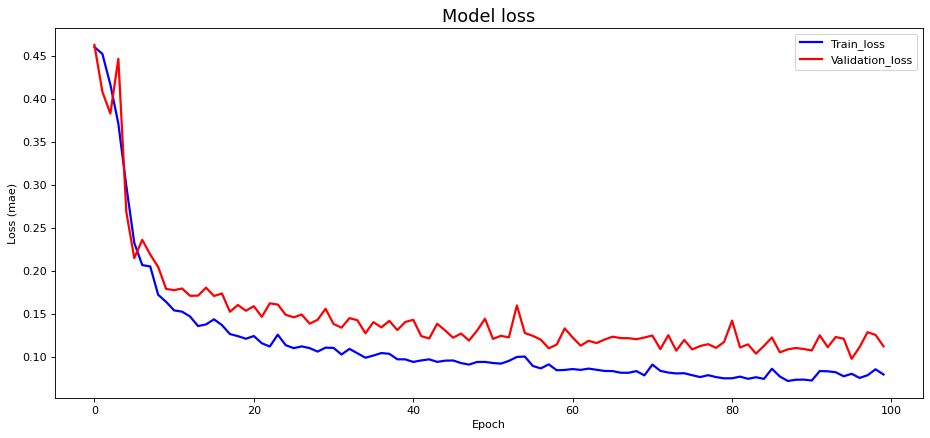

In [78]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train_loss', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation_loss', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

3/3 [==============================] - 1s 39ms/step


/tmp/ipykernel_764566/439503111.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored, bins = 20, kde= True, color = 'blue');


(0.0, 1.0)

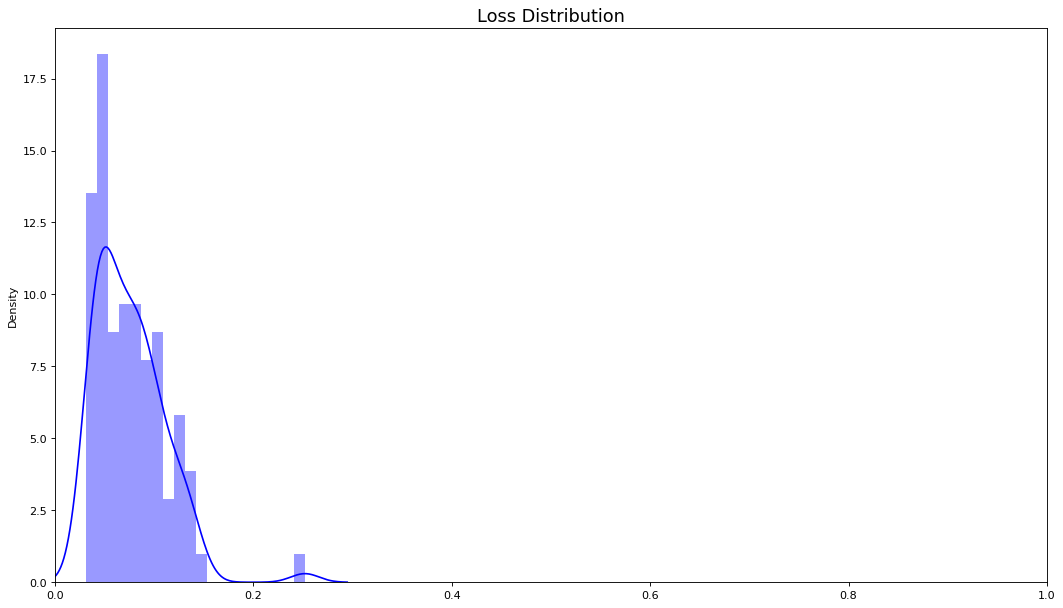

In [79]:
# plot the loss distribution of the training set
X_pred = model3.predict(normal_train_data)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1]*X_pred.shape[2])

Xtrain = normal_train_data.reshape(normal_train_data.shape[0], normal_train_data.shape[1]*normal_train_data.shape[2])
scored = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored, bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,1.0])

In [85]:
threshold = np.mean(scored)+0.5*np.std(scored)
print("Threshold:", threshold)

Threshold: 0.09339895180625024


Text(0.5, 1.0, 'A normal trajectory')

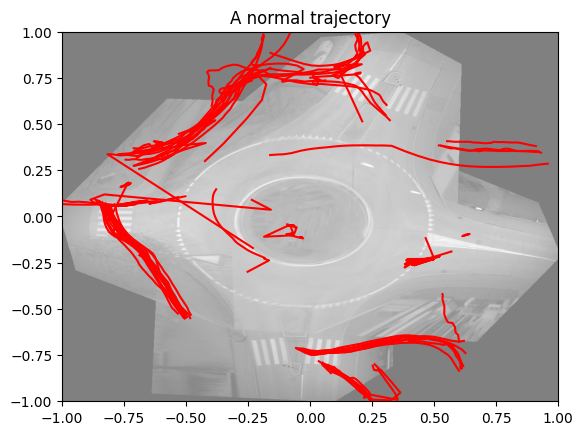

In [86]:
background_image = mpimg.imread("/home/coder/viscando/data/Viscando_Koelliken_Trajectory_data/Koelliken_background_image.png") # ../data/imagge
# Set the threshold score

# Filter the normal_train_data based on the threshold score
filtered_data = normal_train_data[scored < threshold]

# # Reshape the filtered data if needed
# filtered_data = filtered_data.reshape(filtered_data.shape[0], filtered_data.shape[1], filtered_data.shape[2])
fig, ax = plt.subplots()
ax.imshow(background_image, cmap='gray', extent=[-1,1,-1,1], alpha = 0.5, aspect='auto')
# Plot the filtered data
for i in range(len(filtered_data)):
    ax.plot(filtered_data[i][:,0], filtered_data[i][:,1], '-r')
ax.set_title("A normal trajectory")
#ax.show()

Text(0.5, 1.0, 'A abnormal trajectory')

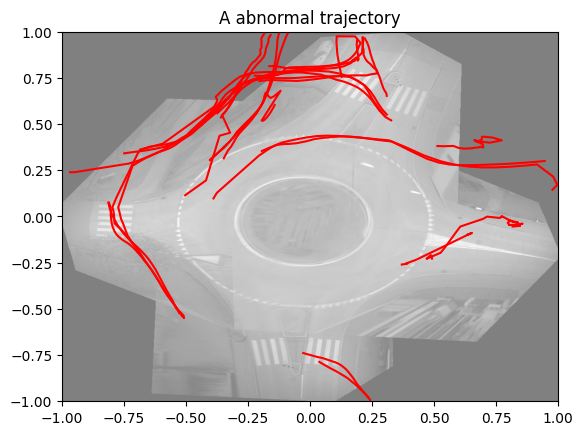

In [87]:
background_image = mpimg.imread("/home/coder/viscando/data/Viscando_Koelliken_Trajectory_data/Koelliken_background_image.png") # ../data/imagge
# Set the threshold score

# Filter the normal_train_data based on the threshold score
filtered_data = normal_train_data[scored > threshold]

# # Reshape the filtered data if needed
# filtered_data = filtered_data.reshape(filtered_data.shape[0], filtered_data.shape[1], filtered_data.shape[2])
fig, ax = plt.subplots()
ax.imshow(background_image, cmap='gray', extent=[-1,1,-1,1], alpha = 0.5, aspect='auto')
# Plot the filtered data
for i in range(len(filtered_data)):
    ax.plot(filtered_data[i][:,0], filtered_data[i][:,1], '-r')
ax.set_title("A abnormal trajectory")
#ax.show()